In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [13]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])
#Image_RGB =(1- ( (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))))*2 - 1

Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

8645


In [14]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
#show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


In [79]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)


/home/sunhao/anaconda3/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [80]:
autoencoder.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(train_data[12000:14000],train_data[12000:14000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2000 samples
Epoch 1/100
12000/12000 [==============================] - 15s - loss: 1.8920 - val_loss: 0.4299
Epoch 2/100
12000/12000 [==============================] - 13s - loss: 0.2243 - val_loss: 0.3341
Epoch 3/100
12000/12000 [==============================] - 13s - loss: 0.1813 - val_loss: 0.2876
Epoch 4/100
12000/12000 [==============================] - 13s - loss: 0.1623 - val_loss: 0.1955
Epoch 5/100
12000/12000 [==============================] - 13s - loss: 0.1522 - val_loss: 0.1502
Epoch 6/100
12000/12000 [==============================] - 13s - loss: 0.1453 - val_loss: 0.1541
Epoch 7/100
12000/12000 [==============================] - 13s - loss: 0.1373 - val_loss: 0.1411
Epoch 8/100
12000/12000 [==============================] - 13s - loss: 0.1322 - val_loss: 0.1507
Epoch 9/100
12000/12000 [==============================] - 13s - loss: 0.1287 - val_loss: 0.1694
Epoch 10/100
12000/12000 [==============================] - 13s - loss: 0.1254

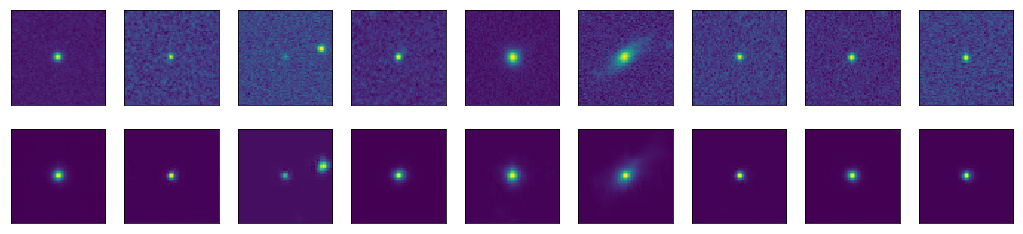

In [81]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = autoencoder.predict(train_data[100:9500],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[100:9500][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [82]:
encoder = Model(inputs=input_img, outputs=encoded)

In [83]:
encoded_variables = encoder.predict(train_data,batch_size=100)

In [84]:
encoded_variables.shape

(14142, 30)

In [85]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=3, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [86]:
classifier.fit(encoded_variables, label, batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2)

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 11313 samples, validate on 2829 samples
Epoch 1/40
11313/11313 [==============================] - 0s - loss: 0.7121 - acc: 0.7828 - val_loss: 0.5232 - val_acc: 0.8254
Epoch 2/40
11313/11313 [==============================] - 0s - loss: 0.4293 - acc: 0.8437 - val_loss: 0.3917 - val_acc: 0.8579
Epoch 3/40
11313/11313 [==============================] - 0s - loss: 0.3602 - acc: 0.8617 - val_loss: 0.3647 - val_acc: 0.8682
Epoch 4/40
11313/11313 [==============================] - 0s - loss: 0.3401 - acc: 0.8689 - val_loss: 0.3550 - val_acc: 0.8742
Epoch 5/40
11313/11313 [==============================] - 0s - loss: 0.3302 - acc: 0.8729 - val_loss: 0.3503 - val_acc: 0.8756
Epoch 6/40
11313/11313 [==============================] - 0s - loss: 0.3238 - acc: 0.8746 - val_loss: 0.3476 - val_acc: 0.8749
Epoch 7/40
11313/11313 [==============================] - 0s - loss: 0.3189 - acc: 0.8783 - val_loss: 0.3464 - val_acc: 0.8735
Epoch 8/40
11313/11313 [==============================] - 0s -

# Fake_label : QSOs = Stars

In [87]:
Fake_class = np.zeros((Class.shape[0],))
Fake_class = Class
Fake_class[Class==2]=0

In [88]:
Fake_class[:100]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

In [89]:
Fake_label = np_utils.to_categorical(Fake_class, 2)

In [90]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=2, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [91]:
classifier.fit(encoded_variables, Fake_label, batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2,callbacks=[EarlyStopping])

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 11313 samples, validate on 2829 samples
Epoch 1/40
11313/11313 [==============================] - 0s - loss: 0.5116 - acc: 0.7818 - val_loss: 0.3704 - val_acc: 0.8600
Epoch 2/40
11313/11313 [==============================] - 0s - loss: 0.2996 - acc: 0.8823 - val_loss: 0.2670 - val_acc: 0.8922
Epoch 3/40
11313/11313 [==============================] - 0s - loss: 0.2397 - acc: 0.9094 - val_loss: 0.2370 - val_acc: 0.9155
Epoch 4/40
11313/11313 [==============================] - 0s - loss: 0.2214 - acc: 0.9196 - val_loss: 0.2280 - val_acc: 0.9236
Epoch 5/40
11313/11313 [==============================] - 0s - loss: 0.2118 - acc: 0.9243 - val_loss: 0.2194 - val_acc: 0.9191
Epoch 6/40
11313/11313 [==============================] - 0s - loss: 0.2052 - acc: 0.9275 - val_loss: 0.2140 - val_acc: 0.9208
Epoch 7/40
11313/11313 [==============================] - 0s - loss: 0.2001 - acc: 0.9286 - val_loss: 0.2096 - val_acc: 0.9265
Epoch 8/40
11313/11313 [==============================] - 0s -

# Which shows these 30 hidden variables work good in reproduction, and can also work well in classification

In [92]:
np.max(encoded_variables)

1.0

In [93]:
np.std(encoded_variables)

0.55813527

In [94]:
np.min(encoded_variables)

-1.0

In [95]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

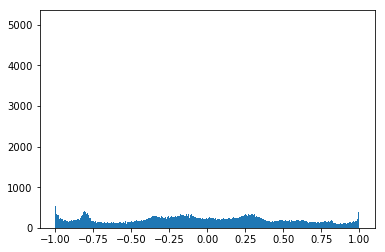

In [96]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [97]:
net_3_input= Input(shape=(30,))
encoded = Dense(2, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [98]:
autoencoder.fit(Zero_one_normalized_encoded_variables[:12000], Zero_one_normalized_encoded_variables[:12000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(Zero_one_normalized_encoded_variables[12000:14000],Zero_one_normalized_encoded_variables[12000:14000]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2000 samples
Epoch 1/100
12000/12000 [==============================] - 0s - loss: 0.2869 - val_loss: 0.2363
Epoch 2/100
12000/12000 [==============================] - 0s - loss: 0.2102 - val_loss: 0.1796
Epoch 3/100
12000/12000 [==============================] - 0s - loss: 0.1648 - val_loss: 0.1455
Epoch 4/100
12000/12000 [==============================] - 0s - loss: 0.1399 - val_loss: 0.1295
Epoch 5/100
12000/12000 [==============================] - 0s - loss: 0.1280 - val_loss: 0.1209
Epoch 6/100
12000/12000 [==============================] - 0s - loss: 0.1200 - val_loss: 0.1141
Epoch 7/100
12000/12000 [==============================] - 0s - loss: 0.1134 - val_loss: 0.1085
Epoch 8/100
12000/12000 [==============================] - 0s - loss: 0.1083 - val_loss: 0.1042
Epoch 9/100
12000/12000 [==============================] - 0s - loss: 0.1045 - val_loss: 0.1009
Epoch 10/100
12000/12000 [==============================] - 0s - loss: 0.1016 - val_los

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


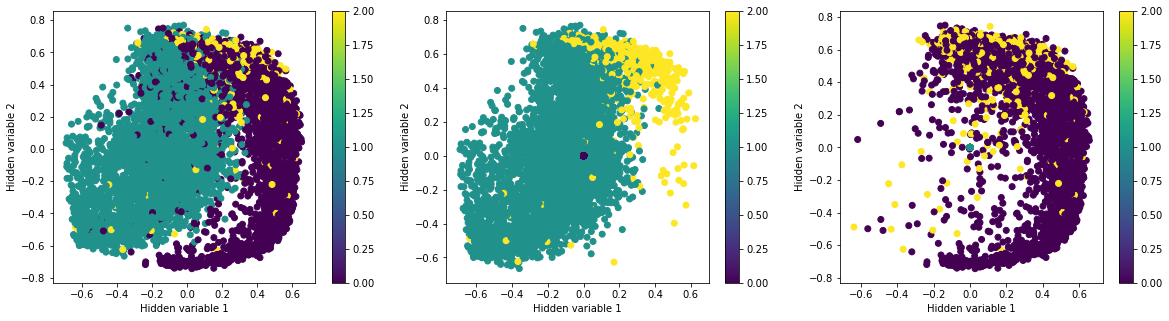

In [99]:
lower_lim = 0
upper_lim = 14100

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [101]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(Zero_one_normalized_encoded_variables, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

In [144]:
Y_pred.reshape(-1,).shape

(14142,)

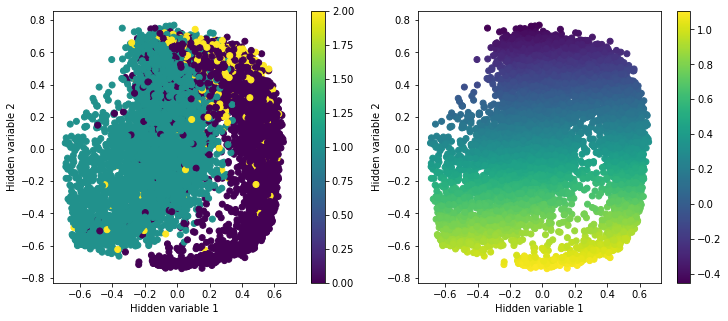

In [120]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred.reshape(-1,)[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

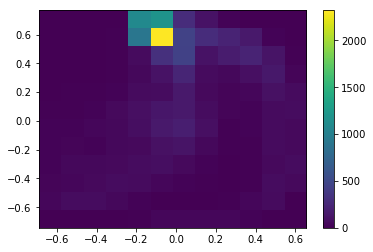

In [145]:
plt.hist2d(x_vis[:,0],x_vis[:,1],12)
plt.colorbar()
plt.show()

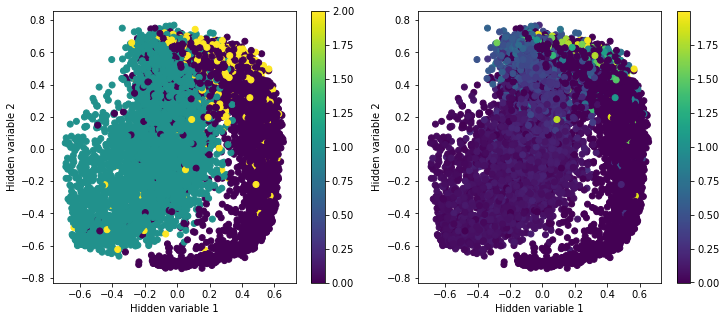

In [135]:
plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Redshift[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

# those figures show that stars and galaxies that with high redshift are harder to be classified

In [163]:
"""hidden 1 < 0.4"""

'hidden 1 < 0.4'

In [164]:
Zero_one_normalized_encoded_variables.shape

(14142, 30)

In [165]:
Mark = np.zeros((Zero_one_normalized_encoded_variables.shape[0],))

In [166]:
Mark[x_vis[:,1]>0.4] = 1

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 14142 but corresponding boolean dimension is 14100
  """Entry point for launching an IPython kernel.


In [167]:
sub_variable = []
sub_label = []

for i in range(Zero_one_normalized_encoded_variables.shape[0]):
    if Mark[i]==1:
        sub_variable.append(Zero_one_normalized_encoded_variables[i])
        sub_label.append(label_value[i])

In [168]:
sub_variable = np.asarray(sub_variable)
sub_label = np.asarray(sub_label)

In [169]:
net_3_input= Input(shape=(30,))
encoded = Dense(2, activation='tanh')(net_3_input)
decoded = Dense(30, activation='tanh')(encoded)

autoencoder = Model(input=net_3_input, output=decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [194]:
net_3_input= Input(shape=(30,))
h_1 = Dense(15, activation='tanh')(net_3_input)

z_mean = Dense(2)(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=1.0)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)

def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.binary_crossentropy(x ,decoded)),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 0*kl_loss

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)


/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [195]:
vae.fit(sub_variable[:8000], sub_variable[:8000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 0s - loss: -25.8993 - val_loss: -47.0361
Epoch 2/100
6400/6400 [==============================] - 0s - loss: -70.3256 - val_loss: -102.2046
Epoch 3/100
6400/6400 [==============================] - 0s - loss: -135.0656 - val_loss: -162.0624
Epoch 4/100
6400/6400 [==============================] - 0s - loss: -185.2115 - val_loss: -209.6906
Epoch 5/100
6400/6400 [==============================] - 0s - loss: -219.1278 - val_loss: -228.9352
Epoch 6/100
6400/6400 [==============================] - 0s - loss: -237.1312 - val_loss: -243.7961
Epoch 7/100
6400/6400 [==============================] - 0s - loss: -247.9134 - val_loss: -252.8862
Epoch 8/100
6400/6400 [==============================] - 0s - loss: -252.7121 - val_loss: -256.0912
Epoch 9/100
6400/6400 [==============================] - 0s - loss: -256.6053 - val_loss: -259.0878
Epoch 10/100
6400/6400 [==============================]

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


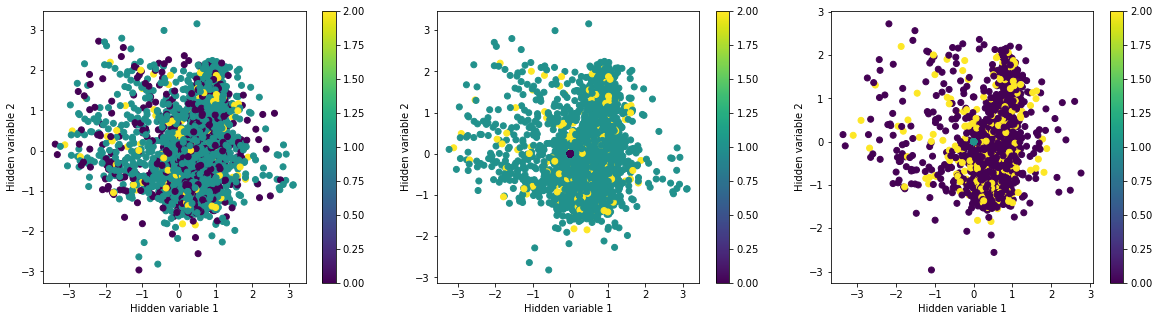

In [196]:
lower_lim = 0
upper_lim = 8000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [171]:
sub_variable.shape

(8583, 30)

In [172]:
autoencoder.fit(sub_variable, sub_variable,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 6866 samples, validate on 1717 samples
Epoch 1/100
6866/6866 [==============================] - 0s - loss: 0.1189 - val_loss: 0.0992
Epoch 2/100
6866/6866 [==============================] - 0s - loss: 0.0938 - val_loss: 0.0828ss: 0.
Epoch 3/100
6866/6866 [==============================] - 0s - loss: 0.0823 - val_loss: 0.0755
Epoch 4/100
6866/6866 [==============================] - 0s - loss: 0.0765 - val_loss: 0.0709
Epoch 5/100
6866/6866 [==============================] - 0s - loss: 0.0723 - val_loss: 0.0672
Epoch 6/100
6866/6866 [==============================] - 0s - loss: 0.0689 - val_loss: 0.0641
Epoch 7/100
6866/6866 [==============================] - 0s - loss: 0.0661 - val_loss: 0.0615
Epoch 8/100
6866/6866 [==============================] - 0s - loss: 0.0637 - val_loss: 0.0593
Epoch 9/100
6866/6866 [==============================] - 0s - loss: 0.0617 - val_loss: 0.0575
Epoch 10/100
6866/6866 [==============================] - 0s - loss: 0.0602 - val_loss: 0.0562
Epoch

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


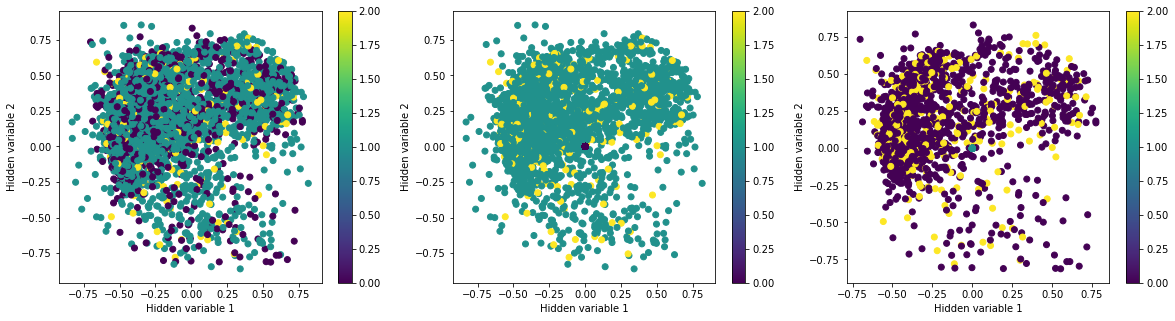

In [175]:
lower_lim = 0
upper_lim = 8000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input=net_3_input, output=encoded)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(sub_variable[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

In [204]:
net_2_input= Input(shape=(30,))
FC_1 = Dense(units=15, activation='relu')(net_2_input)
net_2_output = Dense(units=3, activation='sigmoid')(FC_1)

classifier = Model(net_2_input,net_2_output)
classifier.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='auto')

In [205]:
sub_label_cat = np_utils.to_categorical(sub_label, 3)
classifier.fit(sub_variable, sub_label_cat, batch_size=100, nb_epoch=40,shuffle=True,verbose=1,validation_split=0.2,callbacks=[EarlyStopping])

/home/sunhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6866 samples, validate on 1717 samples
Epoch 1/40
6866/6866 [==============================] - 0s - loss: 0.8746 - acc: 0.6408 - val_loss: 0.7484 - val_acc: 0.6902
Epoch 2/40
6866/6866 [==============================] - 0s - loss: 0.6972 - acc: 0.7024 - val_loss: 0.6436 - val_acc: 0.7315
Epoch 3/40
6866/6866 [==============================] - 0s - loss: 0.5986 - acc: 0.7598 - val_loss: 0.5597 - val_acc: 0.7793
Epoch 4/40
6866/6866 [==============================] - 0s - loss: 0.5247 - acc: 0.7865 - val_loss: 0.5026 - val_acc: 0.8031
Epoch 5/40
6866/6866 [==============================] - 0s - loss: 0.4748 - acc: 0.8050 - val_loss: 0.4687 - val_acc: 0.8154
Epoch 6/40
6866/6866 [==============================] - 0s - loss: 0.4454 - acc: 0.8152 - val_loss: 0.4513 - val_acc: 0.8253
Epoch 7/40
6866/6866 [==============================] - 0s - loss: 0.4288 - acc: 0.8227 - val_loss: 0.4418 - val_acc: 0.8299
Epoch 8/40
6866/6866 [==============================] - 0s - loss: 0.4186 - a